# Analyze A/B Test Results 

## Table of Contents: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision. 


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

### 1.1 Reading data & first look
Now, we read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>



**a.** Reading in the dataset from the `ab_data.csv` file and taking a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group == "control" and landing_page != "old_page"').shape[0] 

3893

**f.** Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [1]:
# no rows have missing values

### 1.2  Inacurate rows
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**a.**
Handling the rows where the group and landing_page columns don't match.

Creating a new dataset that meets the specifications. Store the new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df[(df.group == 'treatment') & (df.landing_page == 'old_page')].index)
df2 = df2.drop(df[(df.group == 'control') & (df.landing_page == 'new_page')].index)
# check number of dropped rows
df.shape[0] - df2.shape[0] 

3893

In [9]:
# Double Check all of the incorrect rows were removed from df2 
# Output should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3  Checking for repetitions

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

**b.** checking for any repeated **user_id** in **df2**.

In [11]:
df2.user_id.count()

290585

In [12]:
df2.user_id.value_counts()[:5]

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

773192 is a repeated user_id

**c.** looking at repeated **user_id** 

In [13]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
df2.drop(df2[(df2.user_id == 773192) & (df2.timestamp == '2017-01-14 02:55:59.590927')].index, inplace=True)
# Check for no duplicates
df2.shape[0] == df.user_id.nunique()

True

In [15]:
# second check for user_id is not repeated anymore
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### 1.4  Calculating Probabilites

**a.** what is probability of an individual converting regardless of the page they receive?<br><br>


In [16]:
p_population = df2.converted.mean()
p_population 

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control = df2.query('group == "control"').converted.mean()
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treat = df2.query('group == "treatment"').converted.mean()
p_treat

0.11880806551510564

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treat - p_control
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
df[df.landing_page == 'new_page'].shape[0] / df.shape[0]

0.5

**e.** Did the new `treatment` group users lead to more conversions?

>**Having the proportion of users that recieved new page the same as those who recieved the old page, and looking at the observed diffrence; it is not significant, but we can't say it is doing worse because the diffrence is not significant.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 



### 2.1 Stating hypothesis terms

>Recall: We just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (1.4.c). 

So we will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

stating hypothesis where **$p_{old}$** and **$p_{new}$**, are the "converted" probability for the old and new pages respectively. Our null and alternative hypotheses (**$H_0$** and **$H_1$**) should be:

>**$H_0$ : $p_{new}$ <= $p_{old}$** 

>**$H_1$ : $p_{new}$ > $p_{old}$**

### 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, we will assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 




**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [23]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br>

In [25]:
# Simulating a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new, p=[1-p_new,p_new])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulating a Sample for the control Group
old_page_converted = np.random.choice([0,1], n_old, p=[1-p_old, p_old])

**g.** Finding the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for our simulated samples from the parts (e) and (f) above. 

In [27]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.00047000030688167105


**h. Sampling distribution** <br>
Re-creating `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used above. 
<br>
Storing all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
# Sampling distribution 
""""
p_diffs = []

for _ in range(10000):
    new_page_converted= np.random.choice([0,1], n_new, p=[1-p_new, p_new])
    old_page_converted= np.random.choice([0,1], n_old, p=[1-p_old, p_old])
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)
"""
# updated (much faster)
new_simulated = np.random.binomial(n_new, p_new, 10000)/n_new
old_simulated = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_simulated - old_simulated
p_diffs

array([-0.00025658, -0.00215649, -0.00159185, ...,  0.00247557,
       -0.00018095,  0.00045873])

**i. Histogram**<br> 
Ploting a histogram of the **p_diffs**. Also, using `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.


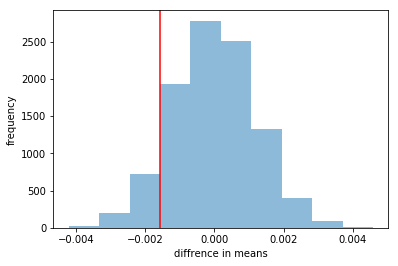

In [29]:
plt.hist(p_diffs, alpha=0.5)
plt.xlabel('diffrence in means')
plt.ylabel('frequency')
plt.axvline(obs_diff, color='r');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [30]:
np.mean(p_diffs > obs_diff)

0.90549999999999997

**k.** Interpretationin for part **j** above.
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? 

>**P-Value = 0.91**

>**p-value >> type I error rate of (0.05).**

>**p-value is large. this suggests that we cannot reject the null hypothesis. we cannot reject the idea that the new page is performing the same or worse than the old one .**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in methods to achieve similar results.

we first calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [31]:
df2[(df2.landing_page == 'old_page')].shape[0]

145274

In [32]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[(df2.landing_page == 'old_page') & (df2.converted)].shape[0]

# number of conversions with the new_page
convert_new = df2[(df2.landing_page == 'new_page') & (df2.converted)].shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2.landing_page == 'old_page'].shape[0]

# number of individuals who received new_page
n_new = df2[df2.landing_page == 'new_page'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` method to compute test statistic and p-value.

The built-in function will return the z_score, p_value. 

---


In [33]:
import statsmodels.api as sm
# Completing sm.stats.proportions_ztest() method arguments
# count = represents the number of "converted" for each group
# nobs = represents the total number of observations (rows) in each group 
count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])

# calculating z-score, and p-value
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** **Interpretation**

What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?

Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Given a Zscore of -1.311 and 𝑍𝛼 of 1.645 (right-tailed). 𝑍score < 𝑍𝛼  (not on the rejection region) this suggests that we fail to reject the null hypothesis.**

>**Also given a p-value of (0.9) (same as what we computed earlier) p-value  is larger than a type 1 error rate of (0.05), agreeing with findings on j. and k. we fail to reject the null hypothesis**

>**Another evidince that the effect on conversion rate regarding the new page is not statistically significant**

<a id='regression'></a>
### Part III - A regression approach

### 3.1 
We will see that the results achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Suitable type of reggression we will be using in this case?

>**Logistic regression**

**b.** first we need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [34]:
df2['intercept'] = 1
df2[['ab_page', 'control']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop(['control'], axis=1)

#check
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Using **statsmodels** to instantiate the regression model on the two created columns, then fit the model to predict whether or not an individual converts.

In [35]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Summary of the model.

In [36]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-04-07 11:01 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** **important Interpretations**
<br>
what is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

>**p-value = 0.19**

>**The regression model assumes that $H_0$ : $p_{new}$ = $p_{old}$ and $H_1$ : $p_{new}$ != $p_{old}$  (two sided hypothesis), but the null hypothesis in part II was $H_0$ : $p_{new}$ <= $p_{old}$ (one-sided)**

>**the new p-value was computed the following way:**

In [37]:
np.mean(p_diffs < obs_diff) + np.mean(p_diffs > np.mean(p_diffs) -obs_diff)

0.188

>**to illustrate this: it's the area on the left of the red line + the area onthe right than the orange line** *shown below

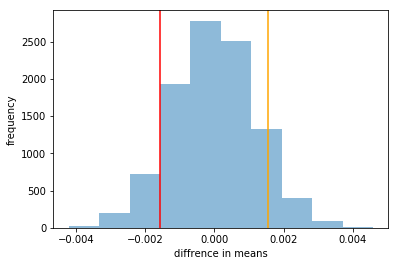

In [38]:
plt.hist(p_diffs, alpha=0.5)
plt.xlabel('diffrence in means')
plt.ylabel('frequency')
plt.axvline(obs_diff, color='r')
plt.axvline(-obs_diff+np.mean(p_diffs), color='orange');

**f.**  considering other things that might influence whether or not an individual converts.
<br>
**Note :**

>**considering the results we got for the p-value so far it suggests that the webpage didn't have a big affect on making an individual convert. So it would be a good idea to study other factors that might be related to conversion rate like which month or marketing factors for example.**

>**There are some disadvantages like multicolinearity problem that may arise when our predictor variables are correlated with one another, non-constant variance, non-linear relationship and many other problems**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, we will add an effect based on which country a user lives in. 

**Steps**

1. Read in the **countries.csv** dataset

2. Merge together with `df2` dataset in a resulting dataframe called  `df_merged`. 

2. Create dummy variables for `['UK', 'US', 'CA']` in the country column.

4. Fit the model for countries. and answer the question: Does it appear that country had an impact on conversion?.


In [39]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [41]:
# Join with the df2 dataframe
df_merged = pd.merge(df2, df_countries, on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [42]:
df_merged.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [43]:
# Creating necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [44]:
# Fitting a model for countries

lm = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK']])

result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-04-07 11:01 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [45]:
np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.9852104557227469, 0.96002111497165088, 1.0099491671175422)

**Interpretation**
>**looking at the p-value assosiated with ab_page p-value = .19 (not so diffrent from the last reggression test), and it tells us that getting the new page does not have a significant change on conversion rate. also by looking at the Coef a user that recives the new page is 0.98 likely to convert than recieving the old page.**

>**CA has a p-value = 0.13 which is greater than alpha = 0.05, so we fail to reject $H_0 :$ CR_CA = CR_US (conversion rate in CA = conversion rate in US). also looking at the coefeccient a user in CA is .96 times likely to convert than being at the US regardless of whether he recieved the new or the old page**

>**UK has a p-value = 0.46 which is greater than alpha = 0.05, so we fail to reject $H_0 :$ CR_UK = CR_US (conversion rate in UK = conversion rate in US). also looking at the coefeccient a user in UK is 1.01 times likely to convert than being at the US regardless of the page is the new or the old one**

>**It doesn't appear that diffrent countries has a significant effect on the conversion rate, because both variables CA and UK  had a p-value that is greater than alpha = 0.05 with a null hypothesis that considers them to be equal in conversion rates to the US** 

>**We can say that conversion rates are not affected much by the new page and the country.**

**h. Fitting a model with an intraction between page & country and obtaining the results**<br> 

we will be Providing the summary results (statistical output), and a conclusions showing statistical & practical significance. 

In [46]:
# Fit your model, and summarize the results
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']

In [51]:
lm = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK', 'CA_ab_page', 'UK_ab_page']])

result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-04-07 11:03 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In [48]:
np.exp(-0.0469), np.exp(0.0314)

(0.95418281110072622, 1.0318981806179213)

**Statistacally:**
>**p-values assosiated with CA, UK, and ab_page has changed due to multicolinearity, because variables CA & ab_page are correlated with  CA_ab_page. also UK & ab_page are correlated with UK_ab_page.**

>**p-values associated with interaction terms CA_ab_page(.38) & UK_ab_page(.24) are greater than alpha of 0.05. so we fail to reject the null hypothesis for both.**

>**also looking at the coeffecients a user in california and recieves new_page is 0.95 times likely to convert when compared to being at the US and recieving the new page, and a user in the UK and recieves new_page is 1.03 times likely to convert when compared to being at the US and recieving the new page.**

>**Both the p-value and the coeffecients suggests that there is no interaction between page and country. because the effects are not statisticaly significant on convertion rates**

**Practically:**
>**My opinion is that the new page shouldn't be lanched and it is a good idea to stick with the old one. it would be time-consuming and expensive to launch a page that didn't prove statistically to be significant and it will need to be provided support and maintainance for the errors that may occur more than the old one that is mostly more stable. ُEffort and money should be spent to look on other factors that may improve the conversion rate like marketing or the time of the year**

In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

resources:

merge dataframe:
https://www.youtube.com/watch?v=wzN1UyfRSWI&ab_channel=ChartExplorers

numoy docs:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

dropping rows with specific conditions:
https://stackoverflow.com/questions/52456874/drop-rows-on-multiple-conditions-in-pandas-dataframe


np.random.binomial
https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html

aslo revisited classroom to refresh some concepts mostly on multiple linear regression model and interpreting the 